In [1]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-06-06 01:42:13--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.12.128, 172.217.194.128, 74.125.200.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.12.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  20.6MB/s    in 5.3s    

2023-06-06 01:42:19 (15.8 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

local_weights_file='/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model=InceptionV3(input_shape=(150,150,3),
                              include_top=False,
                              weights=None)
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable=False

In [4]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [5]:
# Choose `mixed_7` as the last layer of your base model
last_layer=pre_trained_model.get_layer('mixed7')
print('last layer output shape: ',last_layer.output_shape)
last_output=last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [19]:
#Adding Dense layers to classifier
#Adding Dropout layer to prevent overfitting

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

x=layers.Flatten()(last_output)
x=layers.Dense(1024,activation='relu')(x)

#Dropout
x=layers.Dropout(0.2)(x)

x=layers.Dense(1,activation='sigmoid')(x)

model=Model(pre_trained_model.input,x)  #(input,output)

model.summary

model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['acc'])

#Preparing Dataset

In [9]:
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2023-06-06 02:06:05--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 64.233.170.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M  18.0MB/s    in 4.6s    

2023-06-06 02:06:10 (14.4 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [10]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') 

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') 

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [20]:
history=model.fit(
    train_generator,
    validation_data=validation_generator,
    steps_per_epoch=20, #total samples/batch size
    epochs=20,
    validation_steps=50,
    verbose=1
)

Epoch 1/20
20/20 [==============================] - 11s 411ms/step - loss: 4.6521 - acc: 0.6975 - val_loss: 0.2066 - val_acc: 0.9190
Epoch 2/20
20/20 [==============================] - 7s 350ms/step - loss: 0.6056 - acc: 0.8100 - val_loss: 0.1844 - val_acc: 0.9230
Epoch 3/20
20/20 [==============================] - 12s 603ms/step - loss: 0.4094 - acc: 0.8375 - val_loss: 0.2511 - val_acc: 0.8970
Epoch 4/20
20/20 [==============================] - 8s 421ms/step - loss: 0.2603 - acc: 0.8900 - val_loss: 0.1849 - val_acc: 0.9300
Epoch 5/20
20/20 [==============================] - 7s 358ms/step - loss: 0.2731 - acc: 0.8975 - val_loss: 0.1616 - val_acc: 0.9440
Epoch 6/20
20/20 [==============================] - 8s 418ms/step - loss: 0.2882 - acc: 0.8850 - val_loss: 0.1266 - val_acc: 0.9540
Epoch 7/20
20/20 [==============================] - 6s 311ms/step - loss: 0.1789 - acc: 0.9300 - val_loss: 0.1533 - val_acc: 0.9470
Epoch 8/20
20/20 [==============================] - 6s 322ms/step - loss: 

##94% training & 96% val accuracy without dropout
##almost similar result with dropout
###No overfitting

#Evaluating Results

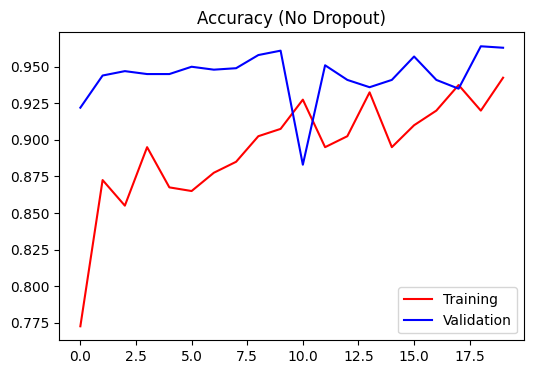

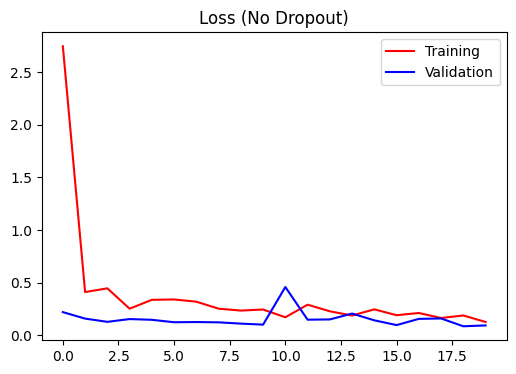

In [18]:
import matplotlib.pyplot as plt

acc=history.history['acc']
loss=history.history['loss']
val_acc=history.history['val_acc']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.figure(figsize=(6,4))
plt.plot(epochs,acc,'r',label="Training")
plt.plot(epochs,val_acc,'blue',label="Validation")
plt.title("Accuracy (No Dropout)")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs,loss,'r',label="Training")
plt.plot(epochs,val_loss,'blue',label="Validation")
plt.title("Loss (No Dropout)")
plt.legend()
plt.show()

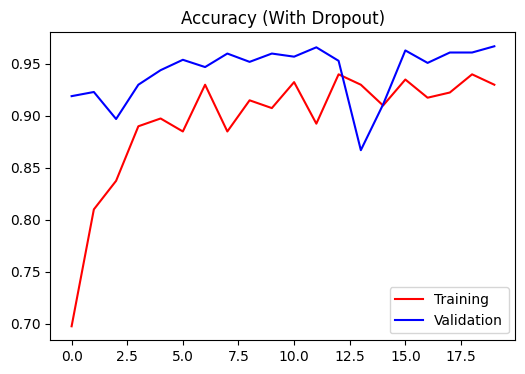

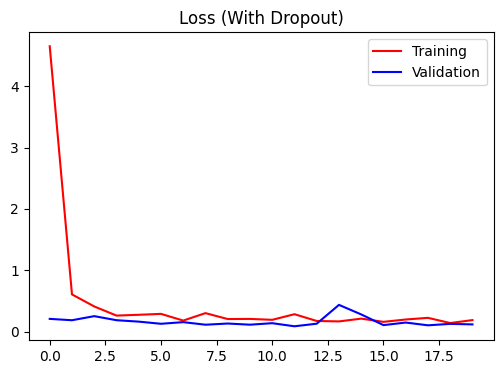

In [21]:
import matplotlib.pyplot as plt

acc=history.history['acc']
loss=history.history['loss']
val_acc=history.history['val_acc']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.figure(figsize=(6,4))
plt.plot(epochs,acc,'r',label="Training")
plt.plot(epochs,val_acc,'blue',label="Validation")
plt.title("Accuracy (With Dropout)")
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs,loss,'r',label="Training")
plt.plot(epochs,val_loss,'blue',label="Validation")
plt.title("Loss (With Dropout)")
plt.legend()
plt.show()